Considering the quickstart_tutorial.py.

This tutorial uses FashionMNIST dataset. This dataset consist in different clothes pictures with 28*28 pixels in gray scale.

To start we import everithing necesary to create a pytorch neural network.

In [338]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

Then we download the FashionMNIST dataset and plot it so we can see some of the images.

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


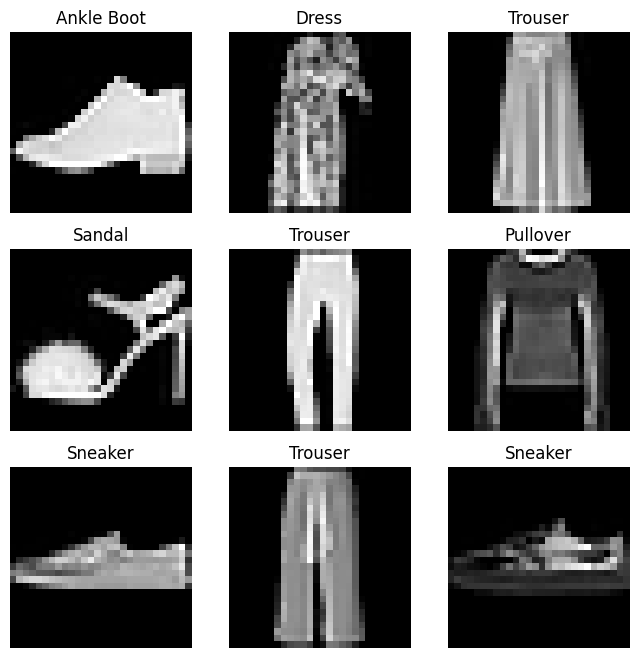

Training data length:  60000
Test data length:  10000


In [339]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# Plot some of the images in the training data
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    print(img.shape)
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Print dataset length
print("Training data length: ", len(training_data))
print("Test data length: ", len(test_data))


Now we pass the Dataset as an argument to DataLoader. This wraps an iterable over our dataset, and support automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.

In [340]:
batch_size = 10000

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([10000, 1, 28, 28])
Shape of y: torch.Size([10000]) torch.int64


Here we can see the shape of X: 64 features of 1*28*28.
And the shape of y: 64 scalars (the label of every image in the batch).

To define a neural network in Pytorch, we create a class that inherits from "nn.Module". We define the layers of the network in the "__innit__" function and specify how data will pass through the network in the "foward" function. To acelerate operations in the neural netwok, we move it to the GPU if available.

In [341]:
#Training in gpu takes more or less 19 seconds with batch size 64
#Training in cpu takes more or less 23 seconds with batch size 64

#Training in gpu takes more or less 18 seconds with batch size 128
#Training in cpu takes more or less 19 seconds with batch size 128

#Training in gpu takes more or less 16 seconds with batch size 10000
#Training in cpu takes more or less 18 seconds with batch size 10000

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Set the model to device
model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


For train a model we need a "loss function" and an "optimizer".

A loss function is a criterion that measure the error between the nn output and the spected output.

An optimizer is an algorithm that adjust the nn parameters.

The most common loss functions and optimizers are already implemented in Pytorch.

In [342]:
loss_fn = nn.CrossEntropyLoss()
sdg_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
adam_optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Now we can define the training loop and the test loop.

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model's parameters.

In [343]:
def train(dataloader, model, loss_fn, optimizer):
    loss_count = []
    size = len(dataloader.dataset)
    model.train() # Set the model to training mode
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X) # The model predicts the class of each image
        loss = loss_fn(pred, y) # The loss function compares the model's prediction and the true label

        # Backpropagation
        optimizer.zero_grad() # Clear gradients from previous step
        loss.backward() # Compute gradients of the loss w.r.t. model parameters
        optimizer.step() # Perform a single optimization step (parameter update)

        loss_count.append(loss.item())
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X) 
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_count

We also check the model's performance against the test dataset to ensure it is learning. 

In [344]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (epochs). During each epoch, the model learns parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the accuracy increase and the loss decrease with every epoch.

In [345]:
epoch = 5
sdg_loss = []
epoch_values = []
for t in range(epoch):
    print("SDG Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    loss_values = train(train_dataloader, model, loss_fn, sdg_optimizer)
    sdg_loss.extend(loss_values)
    test(test_dataloader, model, loss_fn)
    epoch_values.append(len(sdg_loss))
print("Done!")




SDG Optimizer
Epoch 1 
-------------------------------
loss: 2.299729  [    0/60000]
Test Error: 
 Accuracy: 10.8%, Avg loss: 2.299343 

SDG Optimizer
Epoch 2 
-------------------------------
loss: 2.298885  [    0/60000]
Test Error: 
 Accuracy: 11.1%, Avg loss: 2.298509 

SDG Optimizer
Epoch 3 
-------------------------------
loss: 2.298043  [    0/60000]
Test Error: 
 Accuracy: 11.3%, Avg loss: 2.297677 

SDG Optimizer
Epoch 4 
-------------------------------
loss: 2.297201  [    0/60000]
Test Error: 
 Accuracy: 11.6%, Avg loss: 2.296846 

SDG Optimizer
Epoch 5 
-------------------------------
loss: 2.296361  [    0/60000]
Test Error: 
 Accuracy: 11.7%, Avg loss: 2.296017 

Done!


In [346]:
adam_loss = []
for t in range(epoch):
    print("Adam Optimizer")
    print(f"Epoch {t+1} \n-------------------------------")
    loss_values = train(train_dataloader, model, loss_fn, adam_optimizer)
    adam_loss.extend(loss_values)
    test(test_dataloader, model, loss_fn)
print("Done!")

Adam Optimizer
Epoch 1 
-------------------------------
loss: 2.295522  [    0/60000]
Test Error: 
 Accuracy: 63.6%, Avg loss: 1.229276 

Adam Optimizer
Epoch 2 
-------------------------------
loss: 1.220103  [    0/60000]
Test Error: 
 Accuracy: 67.5%, Avg loss: 0.834956 

Adam Optimizer
Epoch 3 
-------------------------------
loss: 0.825326  [    0/60000]
Test Error: 
 Accuracy: 73.5%, Avg loss: 0.718085 

Adam Optimizer
Epoch 4 
-------------------------------
loss: 0.699083  [    0/60000]
Test Error: 
 Accuracy: 76.2%, Avg loss: 0.658994 

Adam Optimizer
Epoch 5 
-------------------------------
loss: 0.636751  [    0/60000]
Test Error: 
 Accuracy: 78.6%, Avg loss: 0.596849 

Done!


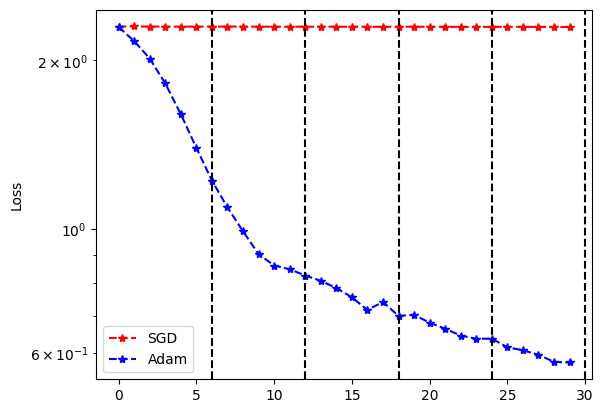

In [351]:
# Plot the loss function
plt.plot(sdg_loss, "--*", label='SGD', color='red')
plt.plot(adam_loss, "--*", label='Adam', color='blue')
for xc in epoch_values:
    plt.axvline(x=xc, color='black', linestyle='--')
plt.yscale('log')
plt.ylabel('Loss')
plt.legend()

Trained models can be saved.
A common way to save the model is to serialize the internal state dictionary (containing the model parameters).

In [348]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


The process for loading a model includes re-creating the model structure and loading the state dictionary into it

In [349]:
loadedModel = NeuralNetwork()
loadedModel.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.

In [350]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

loadedModel.eval() # Put the model in inference mode
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = loadedModel(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"
